# Surface Soil Moisture assessment 

In [95]:
import os
import xarray as xr
import openeo
import pickle
import hvplot.xarray
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path

connection = openeo.connect("openeo.vito.be").authenticate_oidc()

pad = Path(os.getcwd())
if pad.name == "temp":
    pad_correct = pad.parent
    os.chdir(pad_correct)
print(os.getcwd())

execute_job = False
exec_download = False

Authenticated using refresh token.
c:\Users\olivi\Documents\Masterthesis_lokaal\Python


[ 3.66751526 50.76325563  3.83821038 50.90341411]


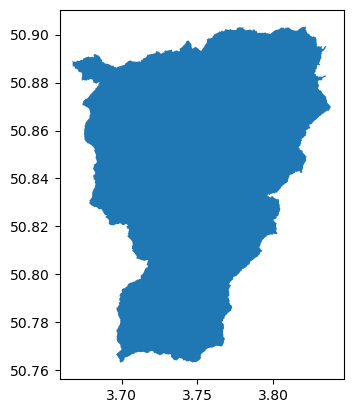

In [96]:
if not os.path.exists('data/Zwalm_shape/zwalm_shapefile_emma.shp'):
    %run "preprocessing_files/shapefile_conversion.py"   
    print('Preprocessing script of Zwalm shapefile has run')
shape_zwalm = gpd.read_file('data/Zwalm_shape/zwalm_shapefile_emma.shp')
shape_zwalm.plot()
extent = shape_zwalm.total_bounds
print(extent)

In [97]:
connection.describe_collection('CGLS_SSM_V1_EUROPE')

{'cube:dimensions': {'bands': {'type': 'bands', 'values': ['ssm']},
  't': {'extent': ['2014-10-03T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-11.0, 50.0],
   'reference_system': 4326,
   'step': 0.008928571428571,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [35.0, 72.0],
   'reference_system': 4326,
   'step': 0.008928571428571,
   'type': 'spatial'}},
 'description': 'Surface Soil Moisture at 1km resolution over Europe, daily. Surface Soil Moisture (SSM) is the relative water content of the top few centimetres soil, describing how wet or dry the soil is in its topmost layer, expressed in percent saturation. It is measured by satellite radar sensors and allows insights in local precipitation impacts and soil conditions.',
 'extent': {'spatial': {'bbox': [[-11.0, 35.0, 50.0, 72.0]]},
  'temporal': {'interval': [['2014-10-03T00:00:00Z', None]]}},
 'id': 'CGLS_SSM_V1_EUROPE',
 'license': 'free',
 'links': [{'href': 'https://land.copernicus.eu/global/products/ssm',
   'rel': 'alternate',
   'title': 'Product web page.'}],
 'stac_extensions': ['https://stac-extensions.github.io/datacube/v2.2.0/schema.json',
  'https://stac-extensions.github.io/eo/v1.1.0/schema.json'],
 'stac_version': '0.9.0',
 'summaries': {},
 'title': 'Copernicus Land Surface Soil Moisture product V1 over Europe, 1km resolution, daily'}

In [98]:
temporal_extent = ["2015-06-07", "2022-11-05"]
collection = 'CGLS_SSM_V1_EUROPE'
spatial_extent = {'west':extent[0],'east':extent[2],'south':extent[1],'north':extent[3]}


In [99]:
ssm = connection.load_collection(
    collection_id = collection,
    spatial_extent= spatial_extent,
    temporal_extent= temporal_extent
)
#ssm = ssm.mask_polygon(shape_zwalm['geometry'].values[0]) TO ADD!
job_ssm = ssm.create_job(title = 'SSM_1km_Zwalm', out_format = 'NetCDF')
display(job_ssm)

<BatchJob job_id='j-65048733a75949e0a27483914e00e6ab'>

In [100]:
ssm_pad = Path('data/SSM_Zwalm')
if not os.path.exists(ssm_pad):
    os.makedirs(ssm_pad)

In [101]:
if execute_job:
    job_ssm.start_job()

In [102]:
with open('data/SSM_Zwalm/job_id.pickle', 'wb') as handle:
    pickle.dump(job_ssm.job_id, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [103]:
filepath = 'data/SSM_Zwalm/SSM_Zwalm.nc'
if exec_download:
    job_id_ssm = pickle.load(open('data/SSM_Zwalm/job_id.pickle',"rb"))
    job_ssm_connection = connection.job(job_id_ssm)
    results = job_ssm_connection.get_results()
    results.download_file(filepath)
    

In [104]:
ssm_zwalm = xr.open_dataset(filepath)
ssm_zwalm

<xarray.Dataset>
Dimensions:  (t: 1659, x: 20, y: 17)
Coordinates:
  * t        (t) datetime64[ns] 2015-06-10 2015-06-13 ... 2022-10-31 2022-11-03
  * x        (x) float64 3.665 3.674 3.683 3.692 ... 3.808 3.817 3.826 3.835
  * y        (y) float64 50.91 50.9 50.89 50.88 ... 50.79 50.78 50.77 50.76
Data variables:
    crs      |S1 ...
    ssm      (t, y, x) uint8 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.11.0a1
    description:  
    title:

https://land.copernicus.eu/global/products/ssm

In [105]:
ssm_zwalm_adapted = ssm_zwalm.copy()
ssm_zwalm_adapted['ssm'] = xr.where(ssm_zwalm['ssm'] > 200, np.nan, ssm_zwalm['ssm'])
ssm_zwalm_adapted['ssm_pv'] = ssm_zwalm_adapted['ssm']*1/200

In [106]:
ssm_zwalm_adapted['ssm_pv'].hvplot.image('x','y',geo = True, crs = 4326)

:DynamicMap   [t]
   :Image   [x,y]   (ssm_pv)

In [107]:
time_series = ssm_zwalm_adapted['ssm_pv'].mean(dim = ['y','x'],skipna=True)
time_series_pd = time_series.to_dataframe()
time_series_pd

,ssm_pv
t,
2015-06-10,0.311009
2015-06-13,0.516879
2015-06-17,NaN
2015-06-18,0.667000
2015-06-25,0.685248
...,...
2022-10-26,0.492480
2022-10-27,0.406306
2022-10-29,NaN


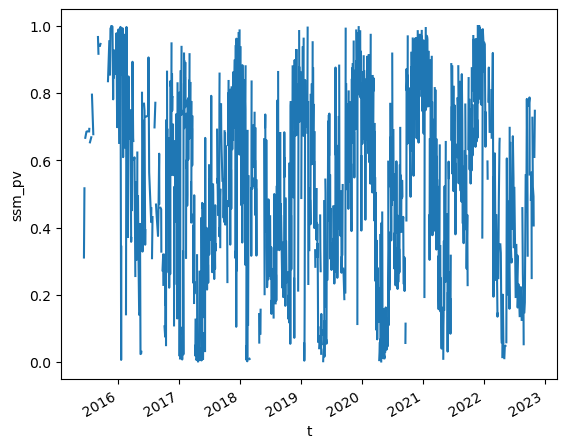

In [108]:
time_series.plot()

In [111]:
pd_zwalm_out_day = pd.read_pickle("data/Zwalm_data/pd_zwalm_out_day.pkl")
pd_zwalm_out_day = pd_zwalm_out_day.reset_index()
pd_zwalm_out_day = pd_zwalm_out_day.rename(columns={'Time':'t'})
pd_zwalm_out_day = pd_zwalm_out_day.set_index('t')
pd_zwalm_out_day.head()

,qmodm3s,Cstar,S1,S3
t,,,,
2012-01-01,0.813979,285.736420,281.609528,0.017944
2012-01-02,1.549312,292.707733,287.667786,0.018269
2012-01-03,1.466663,295.822113,290.341431,0.018334
2012-01-04,1.480345,299.863861,293.799774,0.018422
2012-01-05,2.830086,311.041992,303.183929,0.018642


In [116]:
param = pd.read_csv("data/Zwalm_PDM_parameters/NM_opt_param.csv")
Smax = (param['b'] * param['cmin'] + param['cmax']) / (param['b'] + 1)
Smax = float(Smax.values)  # type:ignore
print(Smax)

561.3559259317367


In [118]:
pd_compare = pd.merge(pd_zwalm_out_day, time_series_pd, how = 'right', on = 't')
pd_compare['sm_pdm'] = pd_compare['S1']/Smax
pd_compare.head()

,qmodm3s,Cstar,S1,S3,ssm_pv,sm_pdm
t,,,,,,
2015-06-10,0.467342,254.643356,253.483078,0.017387,0.311009,0.451555
2015-06-13,0.418099,241.507935,241.058441,0.017038,0.516879,0.429422
2015-06-17,0.370670,228.007828,227.943710,0.016655,NaN,0.406059
2015-06-18,0.555179,233.286301,233.109573,0.016794,0.667000,0.415262
2015-06-25,0.454366,239.744186,239.364182,0.016990,0.685248,0.426404


In [119]:
pd_compare.corr('spearman')

,qmodm3s,Cstar,S1,S3,ssm_pv,sm_pdm
qmodm3s,1.000000,0.928776,0.928758,0.928366,0.427665,0.928758
Cstar,0.928776,1.000000,1.000000,0.999995,0.289863,1.000000
S1,0.928758,1.000000,1.000000,0.999995,0.289847,1.000000
S3,0.928366,0.999995,0.999995,1.000000,0.288976,0.999995
ssm_pv,0.427665,0.289863,0.289847,0.288976,1.000000,0.289847
sm_pdm,0.928758,1.000000,1.000000,0.999995,0.289847,1.000000


<Axes: xlabel='ssm_pv', ylabel='sm_pdm'>

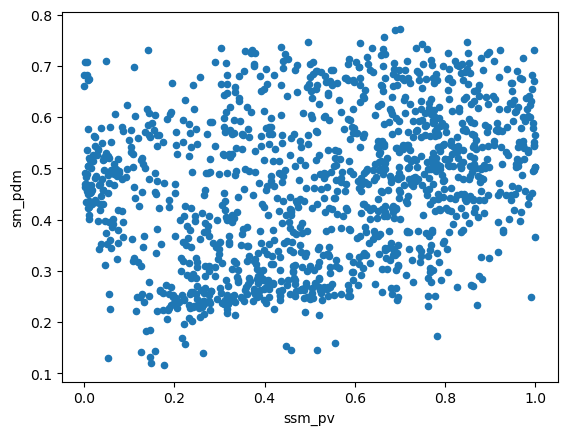

In [120]:
pd_compare.plot.scatter(x= 'ssm_pv', y = 'sm_pdm')

<Axes: xlabel='Cstar', ylabel='qmodm3s'>

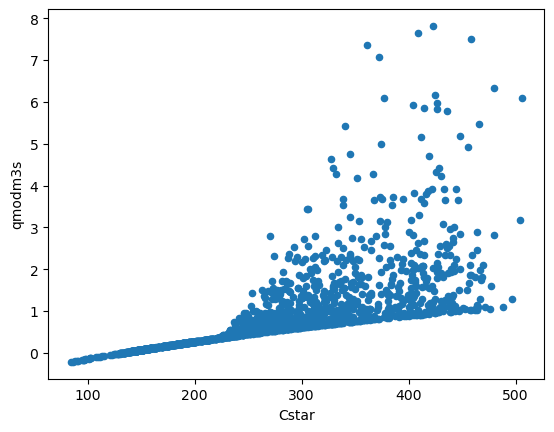

In [94]:
pd_compare.plot.scatter(x = 'Cstar', y = 'qmodm3s')